<h3>Import all the necessary packages</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


<h3>Load data</h3>

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
subm = pd.read_csv('../input/sample_submission.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h3>Split data into train and validation set</h3>

In [4]:
X_train , X_test , y_train , y_test = train_test_split(train.iloc[: , 1:].values , train.iloc[:,0].values , test_size = 0.1) 

<h3>Inspect one sample</h3>

Text(0.5, 1.0, '28x28 data')

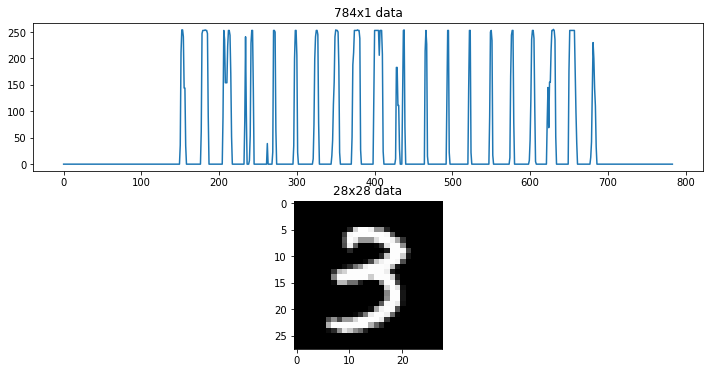

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(X_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(X_train[0].reshape(28,28), cmap='gray')
ax[1].set_title('28x28 data')

<h3> Resize the flattened images into 28x28x1 pixels images and regularize it by dividing it with highest value ie 255</h3>

In [6]:
X_train = X_train.reshape(-1 , 28 , 28 , 1)/255
X_test = X_test.reshape(-1 , 28 , 28 , 1)/255

### OneHot encoding

In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
print(y_train[0])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


### Creating Keras model 

In [9]:
model = Sequential()
model.add(Conv2D(filters = 16 , kernel_size= (3,3) , activation= 'relu' , input_shape = (28 , 28 ,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters= 16 , kernel_size= (3,3) , activation= 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters= 16 , kernel_size= (3,3) , activation= 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Data Augmentation to increate training size

In [10]:
datagen = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [11]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [12]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [13]:
hist = model.fit_generator(datagen.flow(X_train , y_train , batch_size=16) ,
                          steps_per_epoch = 500 ,
                           epochs = 20,
                           verbose =2,
                           callbacks=[annealer]
                          )

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 - 7s - loss: 0.8922 - acc: 0.7084
Epoch 2/20
 - 4s - loss: 0.3596 - acc: 0.8927
Epoch 3/20
 - 5s - loss: 0.3113 - acc: 0.9044
Epoch 4/20
 - 5s - loss: 0.2371 - acc: 0.9311
Epoch 5/20
 - 4s - loss: 0.2248 - acc: 0.9309
Epoch 6/20
 - 4s - loss: 0.1870 - acc: 0.9461
Epoch 7/20
 - 4s - loss: 0.1880 - acc: 0.9424
Epoch 8/20
 - 4s - loss: 0.1664 - acc: 0.9499
Epoch 9/20
 - 4s - loss: 0.1456 - acc: 0.9551
Epoch 10/20
 - 4s - loss: 0.1450 - acc: 0.9570
Epoch 11/20
 - 4s - loss: 0.1287 - acc: 0.9614
Epoch 12/20
 - 4s - loss: 0.1203 - acc: 0.9616
Epoch 13/20
 - 4s - loss: 0.1333 - acc: 0.9629
Epoch 14/20
 - 4s - loss: 0.1138 - acc: 0.9657
Epoch 15/20
 - 4s - loss: 0.1153 - acc: 0.9657
Epoch 16/20
 - 5s - loss: 0.1021 - acc: 0.9699
Epoch 17/20
 - 5s - loss: 0.1035 - acc: 0.9671
Epoch 18/20
 - 4s - loss: 0.1032 - acc: 0.9671
Epoch 19/20
 - 4s - loss: 0.0987 - acc: 0.9705
Epoch 20/20
 - 5s - loss: 0.0961 - acc: 0.9722


In [14]:
final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print('loss =' , final_loss , '\naccuracy' , final_acc)

loss = 0.02551930881848204 
accuracy 0.9930952380952381


<h4>Submit</h4>

In [15]:
test = test.values
test = test.reshape(-1 , 28 , 28 ,1)/255
pre = model.predict(test, batch_size=64)

In [16]:
pre = np.argmax(pre , axis = 1)

In [17]:
pre

array([2, 0, 9, ..., 3, 9, 2])

In [18]:
subm.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [19]:
subm['Label'] = pre

In [20]:
subm.to_csv('submit.csv' , index= False)